In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = torch.device('cuda')

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold

from IPython.display import clear_output
clear_output()

import utils
import data_extraction as da
import extract_sem_representation as esr

import modelling as md
import plotting

test_size = 0.1
cv_val_set_size = 0.2
seed = 42
# TODO: create graph showing experiments with pooling strategies

INFO - 2025-07-10 15:18:34,169 - PyTorch version 2.7.1 available.
[nltk_data] Downloading package stopwords to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_parquet(da.cleaned_dataset_fp).sort_values(['movie', 'start_time'])

for col in md.full_cat_cols:
    df[col] = md.convert_col_to_ordinal(df[col], compact=False)

df['rating'] = df[md.full_cat_cols].max(axis=1)
# df['classification'] = np.select(
#     [df['rating'].eq(ii) for ii in range(1, 6)],
#     md.classifications,
#     default='Error'
# )
    
# Set none values to G (as none makes no sense), set R ratings to MA due to low sample size
ratings = df[md.full_cat_cols + ['movie']].drop_duplicates().drop(columns=['movie']).values
ratings[ratings == 5] = 4
ratings[ratings == 0] = 1

# TODO: experiment with hyperparams
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.5, ngram_range=(1, 3))
k_fold = StratifiedKFold(n_splits=5)
log_reg = LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=int(1e4))

agg_cols = {col: 'first' for col in md.cat_cols + ['rating']}
agg_cols['text'] = lambda x: ' '.join(x)

In [ ]:
log_reg_results = []

for rep_type in md.rep_types:

    curr_df = df.copy()
    if rep_type != 'transcript':
        curr_df = curr_df[curr_df.type.eq(rep_type)].reset_index(drop=True)

    curr_df = curr_df.groupby('movie').agg(agg_cols)
    text_arr = curr_df.text.values

    for cat_idx, cat in enumerate(md.full_cat_cols):
        cat_ratings = ratings[:, cat_idx]
        for train_idx, test_idx in k_fold.split(text_arr, cat_ratings):
            logging.info(f'Cat: {cat}')
            X_train, y_train, X_test, y_test = text_arr[train_idx], cat_ratings[train_idx], text_arr[test_idx], cat_ratings[test_idx]
            X_train_vec = vectorizer.fit_transform(X_train)
            X_test_vec = vectorizer.transform(X_test)
            log_reg.fit(X_train_vec, y_train)

            pred_labels = log_reg.predict(X_test_vec)
            log_reg_results.append({
                'f1_macro': f1_score(y_test, pred_labels, average='macro'),
                'acc': accuracy_score(y_test, pred_labels),
                'cat': cat,
                'rep_type': rep_type
            })

INFO - 2025-07-09 16:53:58,389 - Cat: themes
INFO - 2025-07-09 16:54:08,691 - Cat: themes
INFO - 2025-07-09 16:54:18,011 - Cat: themes
INFO - 2025-07-09 16:54:26,466 - Cat: themes
INFO - 2025-07-09 16:54:34,500 - Cat: themes
INFO - 2025-07-09 16:54:42,104 - Cat: violence
INFO - 2025-07-09 16:54:50,064 - Cat: violence
INFO - 2025-07-09 16:54:57,759 - Cat: violence
INFO - 2025-07-09 16:55:05,462 - Cat: violence
INFO - 2025-07-09 16:55:13,033 - Cat: violence
INFO - 2025-07-09 16:55:20,840 - Cat: language
INFO - 2025-07-09 16:55:28,793 - Cat: language
INFO - 2025-07-09 16:55:36,639 - Cat: language
INFO - 2025-07-09 16:55:44,781 - Cat: language
INFO - 2025-07-09 16:55:52,916 - Cat: language
INFO - 2025-07-09 16:56:00,440 - Cat: drug_use
INFO - 2025-07-09 16:56:08,657 - Cat: drug_use
INFO - 2025-07-09 16:56:16,921 - Cat: drug_use
INFO - 2025-07-09 16:56:25,015 - Cat: drug_use
INFO - 2025-07-09 16:56:33,106 - Cat: drug_use
INFO - 2025-07-09 16:56:41,045 - Cat: nudity
INFO - 2025-07-09 16:56:4

In [7]:
# TODO: experiment with hyperparams
svm = SGDClassifier(n_jobs=-1)

agg_cols = {col: 'first' for col in md.cat_cols + ['rating']}
agg_cols['text'] = lambda x: ' '.join(x)

svm_results = []

for rep_type in ['dialogue']: #md.rep_types:

    curr_df = df.copy()
    if rep_type != 'transcript':
        curr_df = curr_df[curr_df.type.eq(rep_type)].reset_index(drop=True)

    curr_df = curr_df.groupby('movie').agg(agg_cols)
    text_arr = curr_df.text.values

    for cat_idx, cat in enumerate(md.full_cat_cols):
        cat_ratings = ratings[:, cat_idx]
        for train_idx, test_idx in k_fold.split(text_arr, cat_ratings):
            logging.info(f'Cat: {cat}')
            X_train, y_train, X_test, y_test = text_arr[train_idx], cat_ratings[train_idx], text_arr[test_idx], cat_ratings[test_idx]
            X_train_vec = vectorizer.fit_transform(X_train)
            X_test_vec = vectorizer.transform(X_test)

            svm.fit(X_train_vec, y_train)
            pred_labels = svm.predict(X_test_vec)
            
            svm_results.append({
                'f1_macro': f1_score(y_test, pred_labels, average='macro'),
                'acc': accuracy_score(y_test, pred_labels),
                'cat': cat,
                'rep_type': rep_type
            })

INFO - 2025-07-09 23:05:16,269 - Cat: themes
INFO - 2025-07-09 23:05:23,000 - Cat: themes
INFO - 2025-07-09 23:05:29,927 - Cat: themes
INFO - 2025-07-09 23:05:37,374 - Cat: themes
INFO - 2025-07-09 23:05:44,633 - Cat: themes
INFO - 2025-07-09 23:05:51,864 - Cat: violence
INFO - 2025-07-09 23:05:59,237 - Cat: violence
INFO - 2025-07-09 23:06:06,685 - Cat: violence
INFO - 2025-07-09 23:06:13,949 - Cat: violence
INFO - 2025-07-09 23:06:21,295 - Cat: violence
INFO - 2025-07-09 23:06:28,587 - Cat: language
INFO - 2025-07-09 23:06:35,880 - Cat: language
INFO - 2025-07-09 23:06:43,445 - Cat: language
INFO - 2025-07-09 23:06:50,748 - Cat: language
INFO - 2025-07-09 23:06:58,239 - Cat: language
INFO - 2025-07-09 23:07:05,646 - Cat: drug_use
INFO - 2025-07-09 23:07:13,083 - Cat: drug_use
INFO - 2025-07-09 23:07:20,604 - Cat: drug_use
INFO - 2025-07-09 23:07:27,883 - Cat: drug_use
INFO - 2025-07-09 23:07:35,273 - Cat: drug_use
INFO - 2025-07-09 23:07:42,595 - Cat: nudity
INFO - 2025-07-09 23:07:4

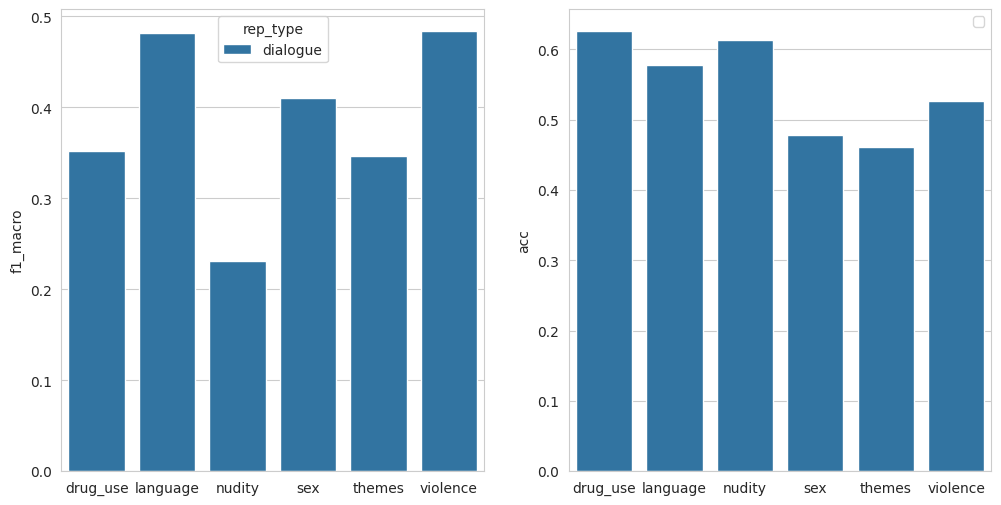

In [8]:
log_reg_results_df = pd.DataFrame(svm_results).groupby(['cat', 'rep_type']).agg({'acc': 'mean', 'f1_macro': 'mean'}).reset_index()

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.barplot(
    data=log_reg_results_df, #kind='bar',
    x='cat', y='f1_macro', hue='rep_type',
    ax=axes[0]
)
axes[0].set_xlabel('')

sns.barplot(
    data=log_reg_results_df, #kind='bar',
    x='cat', y='acc', hue='rep_type',
    ax=axes[1]
)
axes[1].set_xlabel('')
axes[1].legend([])
plt.show()

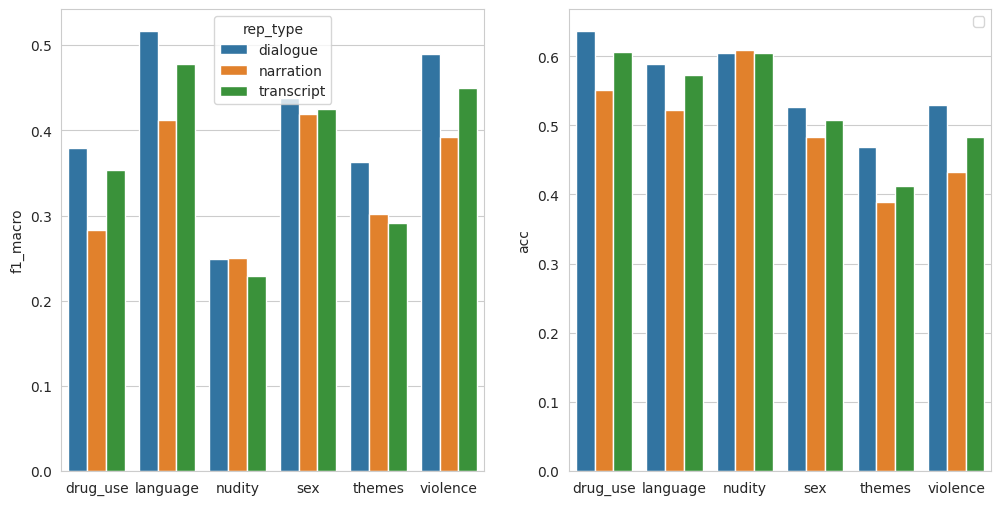

In [56]:
log_reg_results_df = pd.DataFrame(log_reg_results).groupby(['cat', 'rep_type']).agg({'acc': 'mean', 'f1_macro': 'mean'}).reset_index()

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.barplot(
    data=log_reg_results_df, #kind='bar',
    x='cat', y='f1_macro', hue='rep_type',
    ax=axes[0]
)
axes[0].set_xlabel('')

sns.barplot(
    data=log_reg_results_df, #kind='bar',
    x='cat', y='acc', hue='rep_type',
    ax=axes[1]
)
axes[1].set_xlabel('')
axes[1].legend([])
plt.show()

In [3]:
models = [
    'cardiffnlp/twitter-roberta-large-sensitive-multilabel',
    'cardiffnlp/twitter-roberta-base-sentiment-latest',
    'mrm8488/t5-base-finetuned-imdb-sentiment'
]
cases = esr.get_cases(models[:1], ['dialogue'], ['chunks'], md.pooling_strategies[1:])

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  # try 32/64/100 also
from sentence_transformers import SentenceTransformer
import os

In [ ]:
# model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

# raw_utterances_df = pd.read_parquet(da.cleaned_dataset_fp)
# sorted_utterances_df = raw_utterances_df.sort_values(['movie', 'start_time'])
# sorted_utterances_df['idx'] = np.arange(sorted_utterances_df.shape[0])
# embed_idx_df = sorted_utterances_df.groupby('movie').idx.agg([('start_idx', 'min'), ('end_idx', 'max')]).reset_index()

# test_embed = model.encode(list(sorted_utterances_df['text']), convert_to_tensor=True).cpu().numpy()
# torch.save(test_embed.cpu(), os.path.join(md.sem_rep_dir, 'all_movies_sent_embed.pt'))
# embed_idx_df.to_parquet(os.path.join(md.sem_rep_dir, 'sent_embed_indices.parquet'))

# X = np.zeros((embed_idx_df.shape[0], 2, 384))

# for ii in range(embed_idx_df.shape[0]):
#     start_idx, end_idx = embed_idx_df.start_idx.iloc[ii], embed_idx_df.end_idx.iloc[ii]
#     X[ii, 0, :] = test_embed[start_idx:end_idx].max()
#     X[ii, 1, :] = test_embed[start_idx:end_idx].mean()

# X = X.reshape(embed_idx_df.shape[0], -1)

INFO - 2025-07-10 11:14:56,846 - Load pretrained SentenceTransformer: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
WARNING - 2025-07-10 11:14:59,214 - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/28325 [00:00<?, ?it/s]

In [17]:
rep_list[0]

tensor([ 0.8706, -0.3596, -0.0540,  ...,  0.4910,  0.1158,  0.6250],
       dtype=torch.float16)

In [16]:
new_rep_list[0]

tensor([ 0.8706, -0.3608, -0.0549,  ...,  0.4912,  0.1165,  0.6245],
       device='cuda:0', dtype=torch.float16)

In [14]:
new_rep_list = esr.get_or_create_movie_sem_reps(df, pooling_model_name, rep_type, packing_type, 'lhs1CLS', device, use_profiler=False)
model_name_fp = md.pooling_models[0].replace('/', '_')
with open(os.path.join(md.sem_rep_dir, f'dialogue_only_rep_list_{model_name_fp}.pkl'), 'rb') as fileobj:
    rep_list = pickle.load(fileobj)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-large-sensitive-multilabel and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]


In [18]:
import pickle
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# basic_svc_model = svm.SVC(class_weight='balanced')
basic_log_reg_model = LogisticRegression(max_iter=100000, n_jobs=-1)
# basic_mlp_model = MLPClassifier(hidden_layer_sizes=(X.shape[-1], 2))
scaler = MinMaxScaler()
preds = []

for pooling_model_name, rep_type, packing_type, pooling_strat in cases:
    # model_name_fp = md.pooling_models[0].replace('/', '_')
    # with open(os.path.join(md.sem_rep_dir, f'dialogue_only_rep_list_{model_name_fp}.pkl'), 'rb') as fileobj:
    #     rep_list = pickle.load(fileobj)
    rep_list = esr.get_or_create_movie_sem_reps(df, pooling_model_name, rep_type, packing_type, pooling_strat, device, use_profiler=False)
    
    # Normalise and stack results
    norm_rep_tensor = torch.nn.functional.normalize(torch.stack(rep_list))
    X = norm_rep_tensor.cpu().numpy().reshape(len(rep_list), -1)
    y = np.array(ratings)

    for ii, cat in enumerate(md.cat_cols):
        y = np.array(ratings)[:, ii]
        for jj, (train_index, test_index) in enumerate(k_fold.split(X, y)):
            X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

            # X_train_scaled = pca.fit_transform(X_train)
            # X_test_scaled = pca.transform(X_test)
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            basic_log_reg_model.fit(X_train_scaled, y_train)
            y_pred = basic_log_reg_model.predict(X_test_scaled)

            curr_log_data = {
                'cat': cat, 
                'model': pooling_model_name, 'rep_type': rep_type, 'packing_type': packing_type, 'pooling_strat': pooling_strat
            }

            curr_mlp_data = {key: val for key, val in curr_log_data.items()}

            curr_log_data['acc'] = accuracy_score(y_test.reshape(-1), y_pred.reshape(-1))
            curr_log_data['f1_macro'] = f1_score(y_test.reshape(-1), y_pred.reshape(-1), average='macro')
            curr_log_data['classifier'] = 'Log Reg'

            # curr_log_data['preds'] = y_pred
            # curr_log_data['true_vals'] = y_test

            print(curr_mlp_data)

            preds.append(curr_log_data)
            preds.append(curr_mlp_data)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-large-sensitive-multilabel and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]


{'cat': 'themes', 'model': 'cardiffnlp/twitter-roberta-large-sensitive-multilabel', 'rep_type': 'dialogue', 'packing_type': 'chunks', 'pooling_strat': 'lhs1CLS'}
{'cat': 'themes', 'model': 'cardiffnlp/twitter-roberta-large-sensitive-multilabel', 'rep_type': 'dialogue', 'packing_type': 'chunks', 'pooling_strat': 'lhs1CLS'}
{'cat': 'themes', 'model': 'cardiffnlp/twitter-roberta-large-sensitive-multilabel', 'rep_type': 'dialogue', 'packing_type': 'chunks', 'pooling_strat': 'lhs1CLS'}
{'cat': 'themes', 'model': 'cardiffnlp/twitter-roberta-large-sensitive-multilabel', 'rep_type': 'dialogue', 'packing_type': 'chunks', 'pooling_strat': 'lhs1CLS'}
{'cat': 'themes', 'model': 'cardiffnlp/twitter-roberta-large-sensitive-multilabel', 'rep_type': 'dialogue', 'packing_type': 'chunks', 'pooling_strat': 'lhs1CLS'}
{'cat': 'violence', 'model': 'cardiffnlp/twitter-roberta-large-sensitive-multilabel', 'rep_type': 'dialogue', 'packing_type': 'chunks', 'pooling_strat': 'lhs1CLS'}
{'cat': 'violence', 'model

In [19]:
preds_metrics_df = pd.DataFrame(preds).groupby(['cat', 'model', 'rep_type', 'packing_type', 'pooling_strat', 'classifier']).agg({
        'acc': 'mean',
        'f1_macro': 'mean', 
    }).reset_index().sort_values(['cat', 'f1_macro'], ascending=False)
preds_metrics_df.iloc[:50]

,cat,model,rep_type,packing_type,pooling_strat,classifier,acc,f1_macro
3,violence,cardiffnlp/twitter-roberta-large-sensitive-mul...,dialogue,chunks,lhs1CLS,Log Reg,0.539130,0.515406
2,themes,cardiffnlp/twitter-roberta-large-sensitive-mul...,dialogue,chunks,lhs1CLS,Log Reg,0.508696,0.449987
1,sex,cardiffnlp/twitter-roberta-large-sensitive-mul...,dialogue,chunks,lhs1CLS,Log Reg,0.652174,0.461594
0,drug_use,cardiffnlp/twitter-roberta-large-sensitive-mul...,dialogue,chunks,lhs1CLS,Log Reg,0.710870,0.685081


In [76]:
all_cats_preds_metrics_df = pd.DataFrame(preds).groupby(['model', 'rep_type', 'packing_type', 'pooling_strat', 'cat']).agg({
        'acc': 'mean',
        'f1_macro': 'mean', 
    }).reset_index()
all_cats_preds_metrics_df[all_cats_preds_metrics_df.pooling_strat.eq('lhs2CLS')].sort_values(['cat', 'f1_macro'], ascending=False)

,model,rep_type,packing_type,pooling_strat,cat,acc,f1_macro
23,mrm8488/t5-base-finetuned-imdb-sentiment,dialogue,chunks,lhs2CLS,violence,0.357184,0.345893
15,cardiffnlp/twitter-roberta-large-sensitive-mul...,dialogue,chunks,lhs2CLS,violence,0.308908,0.296690
7,cardiffnlp/twitter-roberta-base-sentiment-latest,dialogue,chunks,lhs2CLS,violence,0.405042,0.294332
22,mrm8488/t5-base-finetuned-imdb-sentiment,dialogue,chunks,lhs2CLS,themes,0.398459,0.376703
14,cardiffnlp/twitter-roberta-large-sensitive-mul...,dialogue,chunks,lhs2CLS,themes,0.379963,0.357860
6,cardiffnlp/twitter-roberta-base-sentiment-latest,dialogue,chunks,lhs2CLS,themes,0.432497,0.201597
21,mrm8488/t5-base-finetuned-imdb-sentiment,dialogue,chunks,lhs2CLS,sex,0.503318,0.343133
13,cardiffnlp/twitter-roberta-large-sensitive-mul...,dialogue,chunks,lhs2CLS,sex,0.491876,0.315147
5,cardiffnlp/twitter-roberta-base-sentiment-latest,dialogue,chunks,lhs2CLS,sex,0.601829,0.250473
20,mrm8488/t5-base-finetuned-imdb-sentiment,dialogue,chunks,lhs2CLS,drug_use,0.627038,0.355713


In [7]:
preds_metrics_df = pd.DataFrame(preds_metrics)
models_masks = [preds_metrics_df['model'].eq(name) for name in md.pooling_models[:-1]]

preds_metrics_df['abb_model_name'] = np.select(
    models_masks,
    ['cardiff-multilabel', 'cardiff-binary', 'cardif-sentiment', 'emotions', 'imdb-sentiment', 'modernBERT'],
    default='Error'
)
preds_metrics_df['cat'] = preds_metrics_df['rep_type'] + ', ' + preds_metrics_df['packing_type']

NameError: name 'preds_metrics' is not defined

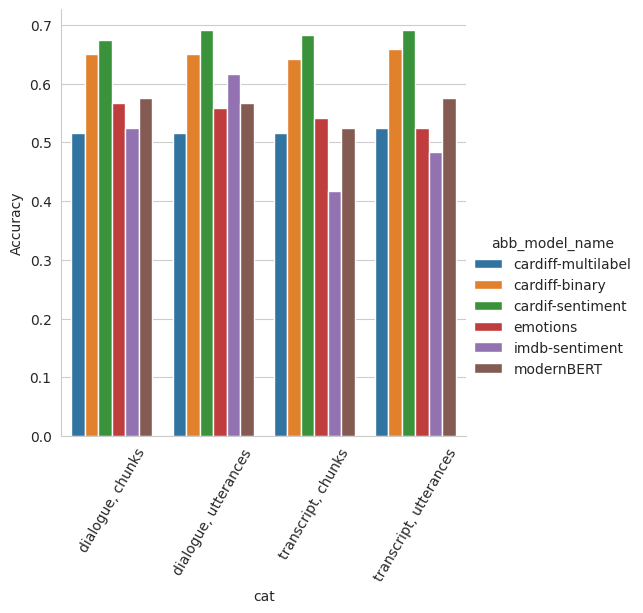

In [ ]:
g = sns.catplot(
    data=preds_metrics_df, kind='bar',
    x='cat', y='acc', hue='abb_model_name',
)
plt.ylabel('Accuracy')
g.set_xticklabels(rotation=60)
plt.show()

In [27]:
mat

array([[14, 11,  6],
       [17,  8,  2],
       [ 6,  6,  6]])

In [32]:
models

['cardiffnlp/twitter-roberta-large-sensitive-multilabel',
 'cardiffnlp/twitter-roberta-base-sentiment-latest',
 'mrm8488/t5-base-finetuned-imdb-sentiment']

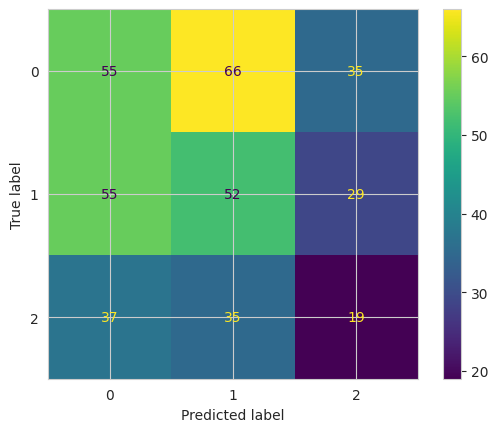

In [33]:
mat = np.zeros((3, 3))

for row in preds:
    if row['model'] == models[-1] and row['cat'] == 'violence':
        mat += confusion_matrix(row['true_vals'], row['preds'])
disp = ConfusionMatrixDisplay(mat)
disp.plot()
plt.show()

In [31]:
29 / (29 + 22 + 19)

0.4142857142857143

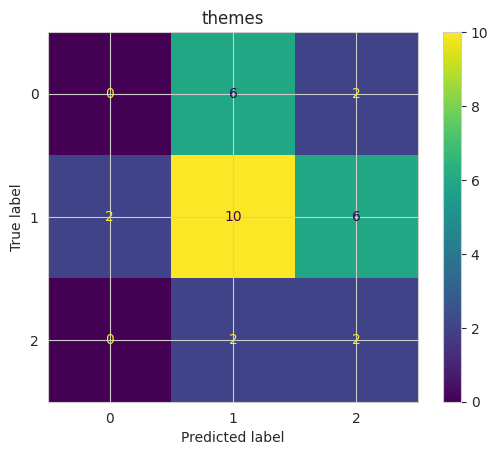

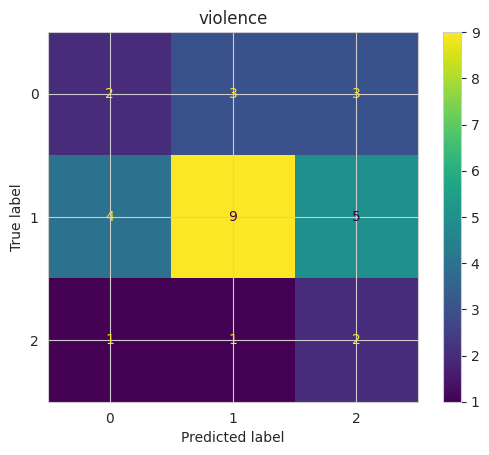

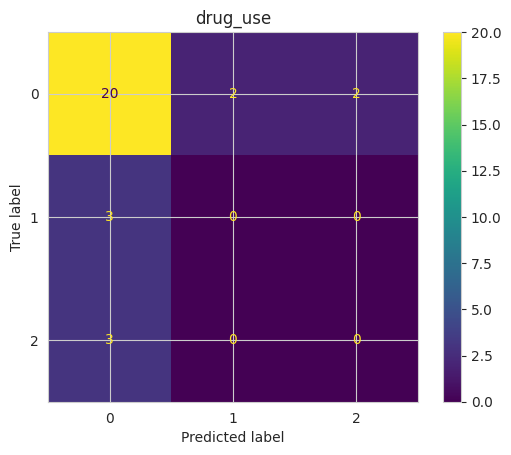

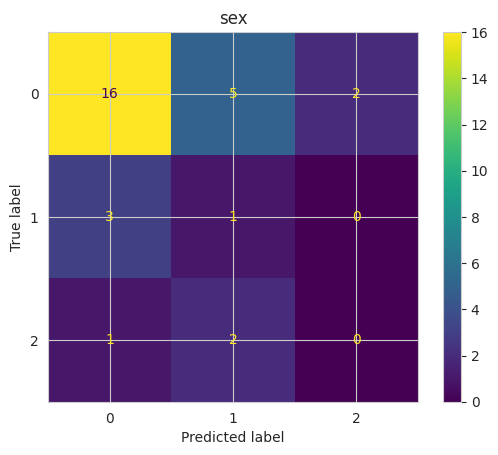

In [ ]:
curr_df = preds_metrics_df[preds_metrics_df.model.eq('cardiffnlp/twitter-roberta-large-sensitive-multilabel') & preds_metrics_df.packing_type.eq('chunks') & preds_metrics_df.rep_type.eq('dialogue')]

for ii, col in enumerate(md.cat_cols):
    curr_cat_preds = preds[1]['preds'][:, ii]
    curr_cat_true = y_test[:, ii]
    mat = confusion_matrix(curr_cat_true, curr_cat_preds)
    disp = ConfusionMatrixDisplay(mat)
    disp.plot()
    plt.title(col)
    plt.show()